# Training a Custom Model Using CSV Files 

In this tutorial, we show how to train your own machine learning classifier for automated spike-sorting curation with UnitRefine. Pre-trained models work well for most datasets, but training a custom model can yield better performance for specific experimental conditions or recording setups.

We demonstrates how to train a custom machine learning classifier for automated spike sorting curation using **pre-computed CSV files**. 


**Note:** This tutorial uses example CSV files. Replace them with your actual quality metrics and manual curation labels for real applications.

## Required Files (located in `data/` folder):
- `data/quality_metrics.csv`: Computed quality metrics for each unit
- `data/cluster_group.tsv`: Manual curation labels (good/mua/noise)
- `data/new_data.csv`: New dataset for applying the trained model

In [ ]:
! pip install spikeinterface[full]

In [5]:
import spikeinterface as si
import spikeinterface.curation as sc
import spikeinterface.widgets as sw

print(f"SpikeInterface version: {si.__version__}")

SpikeInterface version: 0.102.3


Load the Training Data

First, let's load our quality metrics the dataset structure. The quality metrics CSV file contains quantitative measurements for each unit that help distinguish between good units and noise/artifacts.

In [6]:
import os
import pandas as pd

metrics = pd.read_csv('data/quality_metrics.csv')
    
metrics_cols = ['num_spikes', 'firing_rate', 'presence_ratio', 
                'snr', 'amplitude_cutoff', 'amplitude_median', 'amplitude_cv_median', 'amplitude_cv_range',
                'isi_violations_ratio', 'isi_violations_count', 'rp_contamination', 'rp_violations', 'sliding_rp_violation',
                'sync_spike_2', 'sync_spike_4', 'sync_spike_8', 
                'firing_range', 'drift_ptp', 'drift_std', 'drift_mad',
                'isolation_distance', 'l_ratio', 'd_prime', 'silhouette', 'nn_hit_rate', 'nn_miss_rate'
]

print(f"Metrics to be used for training: {len(metrics_cols)} features")

Metrics to be used for training: 26 features


## Load and Process Curation Labels

Now let's load the manual curation labels. These represent expert decisions about unit quality and serve as the "ground truth" for training our classifier.

In [7]:

labels_df = pd.read_csv('data/cluster_group.tsv', sep='\t')
label_counts = labels_df['group'].value_counts()
print(label_counts)
    
label_mapping = {'good': 1, 'mua': 0, 'noise': 0}

labels_df['binary_label'] = labels_df['group'].map(label_mapping)
labels_to_train = labels_df['binary_label'].values

print(f"training labels array: {len(labels_to_train)} labels")

group
mua      403
noise    331
good      62
Name: count, dtype: int64
training labels array: 796 labels


## Train the Classifier

We train a machine learning classifier to distinguish between good and bad units based on the computed metrics. UnitRefine uses an automated pipeline that tests different model configurations to find the best performing combination.


 Model Selection: Tests multiple algorithms (Random Forest, Gradient Boosting, Logistic Regression, etc.)

Data Preprocessing: 
- **Imputation**: Handles missing values using strategies like median, mean, or mode
- **Feature scaling**: Normalizes metrics using StandardScaler, RobustScaler, etc.

For improved model performance and generalization, it's recommended to:
- Use atleast 2 datasets from different recording sessions
- Include diverse experimental conditions (different animals, brain regions, etc.)


In [8]:
folder = "data"

trainer = sc.train_model(
    mode="csv",                                # Use CSV files as input
    labels=[labels_to_train, labels_to_train],  # List of label arrays (one per CSV)
    metrics_paths=['data/quality_metrics.csv', 'data/quality_metrics.csv'],  # List of CSV file paths
    folder=folder,                              # Output directory for model files
    metric_names=metrics_cols,                  # Feature selection (None = use all computed metrics)
    imputation_strategies=["median"],           # How to handle missing values
    scaling_techniques=["standard_scaler"],     # Feature normalization methods
    classifiers=["RandomForestClassifier"],     # many classifier algorithms can be added here
    overwrite=True                              # Overwrite existing model folder
)

# the best performing model
best_model = trainer.best_pipeline

Running RandomForestClassifier with imputation median and scaling StandardScaler()


c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [100, 150] was inferred to Integer(low=100, high=150, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(100, 150), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(2, 4), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [2, 4] was inferred to Integer(low=2, high=4, prior='uniform', transform='identity'). In upcomin

In [9]:
# Display the complete pipeline
best_model

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=4, min_samples_split=4,
                                        n_estimators=150,
                                        random_state=np.int64(1500918033)))])

## Analyze Model Performance

Let's examine how well our trained models performed and understand which configurations worked best.

🔍 Top 10 Most Important Features:
 1. l_ratio                   0.1447
 2. isi_violations_ratio      0.1202
 3. d_prime                   0.1067
 4. rp_contamination          0.1041
 5. sync_spike_2              0.0750
 6. firing_range              0.0635
 7. firing_rate               0.0528
 8. num_spikes                0.0516
 9. nn_hit_rate               0.0433
10. amplitude_median          0.0387


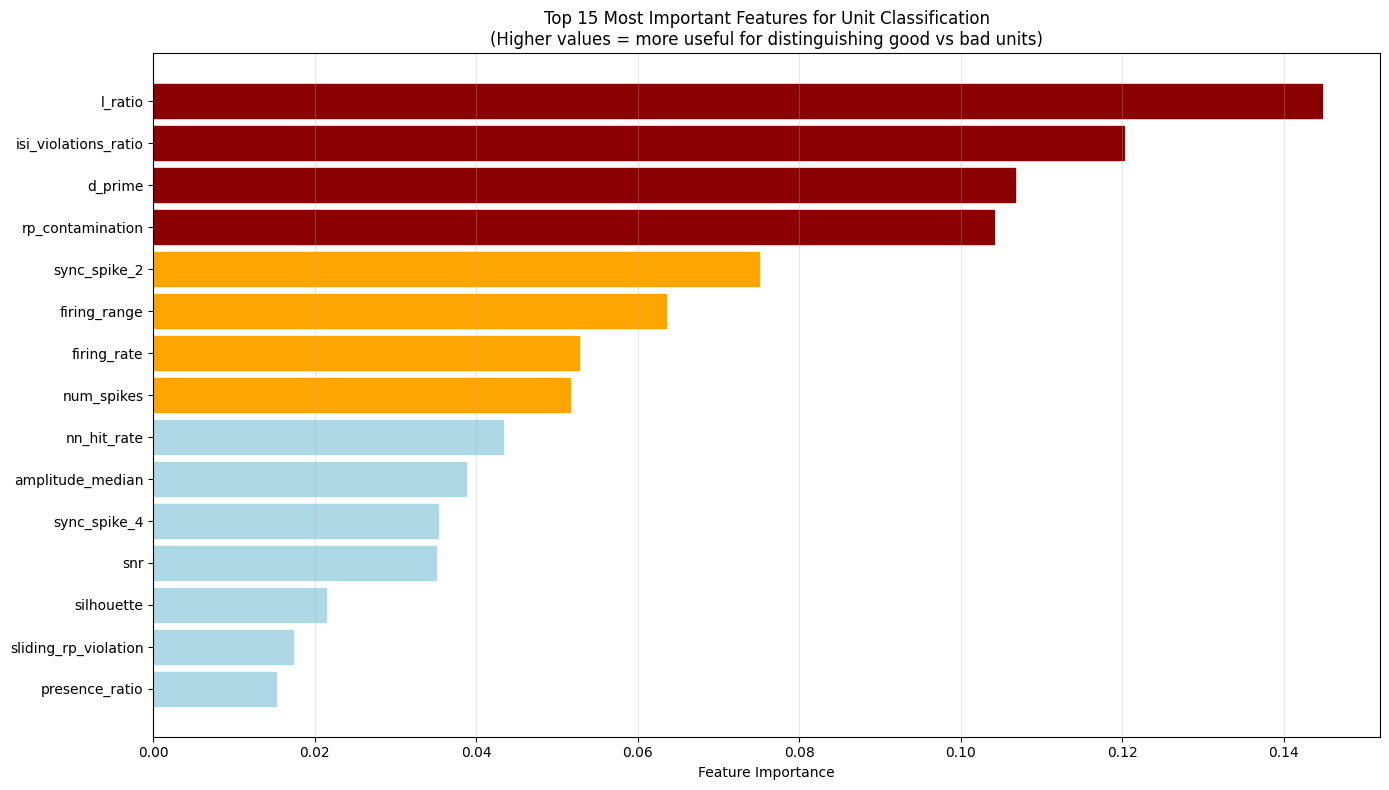

In [10]:
import matplotlib.pyplot as plt

importances = best_model.named_steps['classifier'].feature_importances_
feature_names = best_model.feature_names_in_

# Create a DataFrame for easier analysis
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Display top 10 most important features
print(f"🔍 Top 10 Most Important Features:")
print("=" * 50)
for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
    print(f"{i+1:2d}. {row['feature']:<25} {row['importance']:.4f}")

# Plot feature importances
plt.figure(figsize=(14, 8))
top_features = importance_df.head(15)

bars = plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features for Unit Classification\n(Higher values = more useful for distinguishing good vs bad units)')
plt.gca().invert_yaxis()

# Color code by importance level
for i, bar in enumerate(bars):
    importance = top_features.iloc[i]['importance']
    if importance > 0.1:
        bar.set_color('darkred')
    elif importance > 0.05:
        bar.set_color('orange')
    else:
        bar.set_color('lightblue')

plt.tight_layout()
plt.grid(axis='x', alpha=0.3)
plt.show()

## Bonus: Apply Model to New Data

Now let's test our trained model on new, unseen data to demonstrate how it would be used in practice for automated curation.

### Load New Dataset

We'll load a new CSV file containing quality metrics for units that the model hasn't seen during training.

In [11]:
import pandas as pd
new_data = pd.read_csv('data/new_data.csv')

# Extract features from new dataset (same columns as training data)
new_data_features = new_data[metrics_cols].values

In [13]:
# Apply the trained model to predict unit quality
predictions = best_model.predict(new_data_features)
prediction_probabilities = best_model.predict_proba(new_data_features)

c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
c:\Users\jain\Anaconda3\envs\py311-env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


In [14]:
predictions

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0])

### Save Predictions

Let's save our predictions for future reference and analysis.

In [ ]:
import numpy as np

# Create a results dataframe with predictions
results_df = new_data.copy()
results_df['predicted_quality'] = predictions

# Add prediction confidence
max_probabilities = np.max(prediction_probabilities, axis=1)
results_df['prediction_confidence'] = max_probabilities

# Save predictions to file
output_path = 'data/model_predictions.csv'
results_df.to_csv(output_path, index=False)
print(f"Predictions saved to: {output_path}")
print(f"Saved {len(results_df)} predictions with {results_df.shape[1]} columns")

Predictions saved to: data/model_predictions.csv
Saved 50 predictions with 41 columns
